In [327]:
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

# Import Data from CSV

In [328]:
data = pd.read_csv('20210201_parsed_run3_data.csv',index_col=0)
data['time'] -= 275.036 # let's start at 0 this shouldnt make a difference

In [329]:
data.head()

,time,x,y,psi,vx,vy,r,steer,D,real_ax,real_ay
0,0.00,-101.308861,19.530313,-2.566862,14.049075,0.064813,-0.00306,0.001073,-0.419252,-0.2477,0.5202
1,0.04,-101.002190,19.059580,-2.566963,14.046067,0.070796,-0.00887,0.001056,-0.419129,-0.1003,0.1653
2,0.08,-100.695587,18.588818,-2.567172,14.046994,0.067643,-0.00909,0.001126,-0.413074,-0.0117,0.0054
3,0.12,-100.389305,18.117285,-2.567444,14.055491,0.059404,-0.01306,0.001246,-0.449214,-0.0894,-0.0761
4,0.16,-100.082977,17.645878,-2.567532,14.051016,0.066986,0.00144,0.001262,-0.433608,-0.0839,0.5010


In [330]:
data.tail()

,time,x,y,psi,vx,vy,r,steer,D,real_ax,real_ay
7995,319.80,-167.020935,120.190155,-2.566120,13.627166,0.029047,-0.02381,-0.002339,-4.265322,-5.6695,-0.0485
7996,319.84,-166.724564,119.735992,-2.567150,13.422322,0.042470,-0.02686,-0.001983,-4.274560,-4.9157,0.0203
7997,319.88,-166.433014,119.288536,-2.568222,13.224626,0.034855,-0.02117,-0.001433,-4.278177,-5.2175,-0.7925
7998,319.92,-166.146347,118.847389,-2.569167,13.019039,0.037049,-0.01664,-0.000933,-4.222267,-5.6539,0.3684
7999,319.96,-165.864517,118.413170,-2.569713,12.801240,0.051131,-0.01218,-0.000684,-4.165312,-5.8320,0.4159


In [331]:
data['steer'][4]

0.0012617015647122

# Bicycle Model

In [410]:
def tire_force(alpha, Fz, p):
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p
    return -alpha * cornering_stiff * Fz / sample_fz

def normal_force(vx, p):
    g = 9.8
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
    # traction due to aero
    F_lift = 0.5*rho*cla*(vx**2)
    FzF = -(lr * (m * g + F_lift)) / l;
    FzR = -(lf * (m * g + F_lift)) / l;
    
    return FzF, FzR

def bicycle_model(x, t, p):
    x, y, psi, vx, vy, r = x  # position
    D, steer = data['D'][int(t / 0.04)], data['steer'][int(t / 0.04)] # we will just take these based off the t input
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
    
    # estimate normal
    FzF, FzR = normal_force(vx, p)
    
    # compute slip angles
    alpha_f = math.atan((vy + r * lf) / vx) + steer
    alpha_r = math.atan((vy - r * lr) / vx)
    
    # compute tire forces
    F_yf = tire_force(alpha_f, FzF, p)
    F_yr = tire_force(alpha_r, FzR, p)
    
    # torque to force
    F_net = m * D
    
    # torque vectoring
    F_xf = lf / l * F_net
    F_xr = lr / l * F_net
    
    # accel
    ax = 1/m * (F_xr + F_xf * math.cos(steer) + F_yf * math.sin(steer)) + r * vy
    ay = 1/m * (F_yr - F_xf * math.sin(steer) + F_yf * math.cos(steer)) - r * vx
    a_yaw = 1/Iz * (-lf * F_xf * math.sin(steer) + lf * F_yf * math.cos(steer) - lr * F_yr)
    
    # bicycle model
    new_x = vx * math.cos(psi) - vy * math.sin(psi)  # sin/cos(x), x should be radians.. not sure if our data is in deg/rad
    new_y = vx * math.sin(psi) + vy * math.cos(psi)
    
    return [new_x, new_y, r, ax, ay, a_yaw]
    

In [411]:
# defining our variables for our simulated data
u0 = [data[c][0] for c in data.columns[1:7]]
timespan = 10
num_pts = 25*timespan + 1
t = np.linspace(0, timespan, num_pts)
p0 = (m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla) = (350.0, 3.0, 1.5, 1.5, 550.0, 10000.0, 3430.0, 1.2, -0.5)

In [412]:
sol = odeint(bicycle_model, u0, t, args=(p0,))

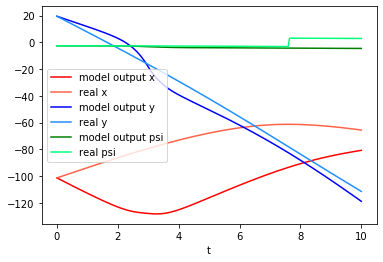

In [414]:
# let's plot this solution to see what it looks like against the real
plt.plot(t, sol[:, 0], 'r', label='model output x')
plt.plot(t, data['x'][:num_pts], 'tomato', label='real x')
plt.plot(t, sol[:, 1], 'b', label='model output y')
plt.plot(t, data['y'][:num_pts], 'dodgerblue', label='real y')
plt.plot(t, sol[:, 2], 'g', label='model output psi')
plt.plot(t, data['psi'][:num_pts], 'springgreen', label='real psi')


plt.legend(loc='best')
plt.xlabel('t')
plt.show()

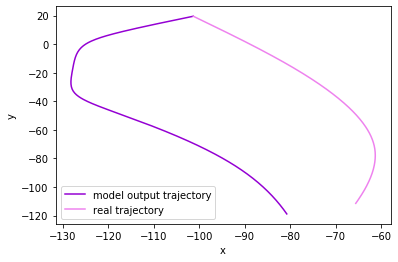

In [416]:
# let's plot just the xy trajectory
plt.plot(sol[:, 0], sol[:, 1], 'darkviolet', label='model output trajectory')
plt.plot(data['x'][:num_pts], data['y'][:num_pts], 'violet', label='real trajectory')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Parameter Estimation

In [428]:
data

,time,x,y,psi,vx,vy,r,steer,D,real_ax,real_ay
0,0.00,-101.308861,19.530313,-2.566862,14.049075,0.064813,-0.00306,0.001073,-0.419252,-0.2477,0.5202
1,0.04,-101.002190,19.059580,-2.566963,14.046067,0.070796,-0.00887,0.001056,-0.419129,-0.1003,0.1653
2,0.08,-100.695587,18.588818,-2.567172,14.046994,0.067643,-0.00909,0.001126,-0.413074,-0.0117,0.0054
3,0.12,-100.389305,18.117285,-2.567444,14.055491,0.059404,-0.01306,0.001246,-0.449214,-0.0894,-0.0761
4,0.16,-100.082977,17.645878,-2.567532,14.051016,0.066986,0.00144,0.001262,-0.433608,-0.0839,0.5010
...,...,...,...,...,...,...,...,...,...,...,...
7995,319.80,-167.020935,120.190155,-2.566120,13.627166,0.029047,-0.02381,-0.002339,-4.265322,-5.6695,-0.0485
7996,319.84,-166.724564,119.735992,-2.567150,13.422322,0.042470,-0.02686,-0.001983,-4.274560,-4.9157,0.0203
7997,319.88,-166.433014,119.288536,-2.568222,13.224626,0.034855,-0.02117,-0.001433,-4.278177,-5.2175,-0.7925
7998,319.92,-166.146347,118.847389,-2.569167,13.019039,0.037049,-0.01664,-0.000933,-4.222267,-5.6539,0.3684


In [429]:
pred = odeint(bicycle_model, u0, t, args=(p0,))
pred.shape

(251, 6)

In [430]:
sol = data[data.time.between(0, timespan)][data.columns[1:7]].to_numpy()

In [431]:
sol.shape

(251, 6)

In [443]:
# TODO: probably want to normalize this error
# l2 = np.square(sol - pred).sum()

def cost(p):
    pred = odeint(bicycle_model, u0, t, args=(p,))
    return np.square(sol - pred).sum()

In [444]:
minimization = minimize(cost, p0, method='Nelder-Mead', tol=100, options={'maxiter':1e3})

In [445]:
def plot_new_params(p):
    new_sol = odeint(bicycle_model, u0, t, args=(p,))
    
    # let's plot this solution to see what it looks like against the real
    plt.plot(t, new_sol[:, 0], 'r', label='model output x')
    plt.plot(t, data['x'][:num_pts], 'tomato', label='real x')
    plt.plot(t, new_sol[:, 1], 'b', label='model output y')
    plt.plot(t, data['y'][:num_pts], 'dodgerblue', label='real y')
    plt.plot(t, new_sol[:, 2], 'g', label='model output psi')
    plt.plot(t, data['psi'][:num_pts], 'springgreen', label='real psi')


    plt.legend(loc='best')
    plt.xlabel('t')
    plt.show()
    
    
    # let's plot just the xy trajectory
    plt.plot(new_sol[:, 0], new_sol[:, 1], 'darkviolet', label='model output trajectory')
    plt.plot(data['x'][:num_pts], data['y'][:num_pts], 'violet', label='real trajectory')
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

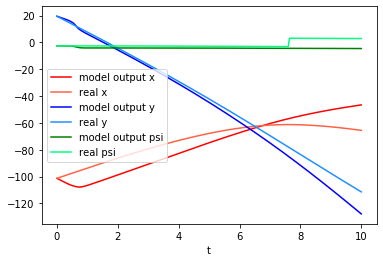

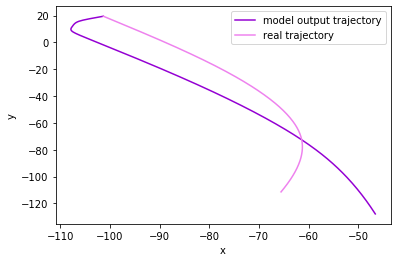

In [446]:
plot_new_params(tuple(minimization.x))

In [447]:
# m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla
minimization.x

array([3.34232956e+02, 4.23100106e+00, 1.92016039e+00, 3.38347404e+00,
       9.50872514e+02, 1.83527785e+04, 2.02510733e+03, 2.06386592e+00,
       2.03446363e+00])

In [448]:
# TODO list:
# - x is going in wrong direction
# - cost function normalization
# - add constraints to the parameters in the minimization
# - make a velocity graph too to observe velocities

# note to self that just matching velocities did not perform so hot lol